## Домашнее задание №2

#### Горская Елена

В ходе выполнения ноутбука будут периодически строиться картинки с тем, как выглядит граф на данной стадии (чтобы было видно, как работает каждая стадия + проверить, что отработала она корректно), однако **итоговые картинки представлены в самом конце ноутбука**.

По алгоритму:
1. Сначала реализован алгоритм Грэхема—Коффмана: *do_graham_coffman(w)*.
2. Затем реализован алгоритм минимизации количества dummy-вершин: *do_dummy_minimize()*.
3. Основной алгоритм: *do_distribute(w=None)*. Если ему на вход подавалось число, то используется первый алгоритм, иначе - второй. Для входного графа я строю параллельно оба этих алгоритма, на графиках сверху подписан алгоритм, который использовался при построении рисунка.
4. Затем идёт добавление dummy-вершин в слои: *add_dummy_vertices()*.
5. Далее, идет минимизация числа пересечений ребер между слоями. Сначала через медиану: *get_minimized_crossings()*. Потом выполняется локальный поиск: *do_local_search()*.
6. В конце ноутбука представлены итоговые рисунки.

In [ ]:
# библиотеки
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
from scipy.optimize import linprog

from google.colab import files

import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

In [ ]:
graphML=b'<?xml version="1.0" encoding="UTF-8"?>\r\n<graphml xmlns="http://graphml.graphdrawing.org/xmlns"  \r\n  xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\r\n  xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns\r\n  http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">\r\n  <graph id="flow" edgedefault="directed">\r\n    <node id="V0"/>\r\n    <node id="V1"/>\r\n    <node id="V2"/>\r\n    <node id="V3"/>\r\n    <node id="V4"/>\r\n    <node id="V5"/>\r\n    <node id="V6"/>\r\n    <node id="V7"/>\r\n    <node id="V8"/>\r\n    <node id="V9"/>\r\n    <node id="V10"/>\r\n    <node id="V11"/>\r\n    <node id="V12"/>\r\n    <node id="V13"/>\r\n    <node id="V14"/>\r\n    <node id="V15"/>\r\n    <node id="V16"/>\r\n    <node id="V17"/>\r\n    <node id="V18"/>\r\n    <node id="V19"/>\r\n    <edge source="V0" target="V5"/>\r\n    <edge source="V0" target="V6"/>\r\n    <edge source="V0" target="V7"/>\r\n    <edge source="V2" target="V5"/>\r\n    <edge source="V2" target="V8"/>\r\n    <edge source="V3" target="V7"/>\r\n    <edge source="V4" target="V6"/>\r\n    <edge source="V4" target="V7"/>\r\n    <edge source="V4" target="V9"/>\r\n    <edge source="V5" target="V9"/>\r\n    <edge source="V5" target="V12"/>\r\n    <edge source="V6" target="V8"/>\r\n    <edge source="V7" target="V8"/>\r\n    <edge source="V7" target="V12"/>\r\n    <edge source="V8" target="V11"/>\r\n    <edge source="V8" target="V14"/>\r\n    <edge source="V8" target="V18"/>\r\n    <edge source="V9" target="V14"/>\r\n    <edge source="V9" target="V16"/>\r\n    <edge source="V10" target="V12"/>\r\n    <edge source="V10" target="V14"/>\r\n    <edge source="V10" target="V19"/>\r\n    <edge source="V11" target="V13"/>\r\n    <edge source="V12" target="V13"/>\r\n    <edge source="V13" target="V17"/>\r\n    <edge source="V14" target="V15"/>\r\n    <edge source="V15" target="V17"/>\r\n    <edge source="V18" target="V19"/>\r\n  </graph>\r\n</graphml>'

В ячейке ниже можно раскомментировать (все 3 строчки!) и загрузить свой граф. Например, отсюда: https://drive.google.com/drive/folders/1optjY-YE9pSo3Oe1awbl9ZmLa_K3A6MB?usp=sharing

In [ ]:
#uploaded = files.upload()
#mykey = list(uploaded.keys())[0]
#graphML = uploaded[mykey]

Saving graph-show.xml to graph-show (1).xml


In [ ]:
# парсинг файла

node_val = "{http://graphml.graphdrawing.org/xmlns}node"
edge_val = "{http://graphml.graphdrawing.org/xmlns}edge"

def parse_graph(xml_file):
  root = ET.fromstring(xml_file)
  nodes = []
  edges = []

  # чтобы вычислить корень
  edges_into = []
  # g - это как раз граф в разметке GraphMl
  g = root[0]

  # ребра храним как список: i-й элемент массива - это список номеров вершин,
  # в которые идут ребра из вершины i
  for node in g.findall(node_val):
    nodes.append(node.get("id"))
  for _ in range(len(nodes)):
    edges.append([])
    edges_into.append([])
  for edge in g.findall(edge_val):
    # номер исходной вершины
    s = nodes.index(edge.get("source"))
    edges[s].append(edge.get("target"))

    t = nodes.index(edge.get("target"))
    edges_into[t].append(edge.get("source"))

  return nodes, edges

In [ ]:
nodes, edges = parse_graph(graphML)

In [ ]:
# для каждой вершины - номера вершин, из которых в нее идут ребра
def find_incomings():
  in_edges = []
  for _ in range(len(nodes)):
    in_edges.append([])

  for i in range(len(edges)):
    for v in edges[i]:
      in_edges[nodes.index(v)].append(int(i))
  return in_edges

def find_children():
  out_edges = []
  for _ in range(len(nodes)):
    out_edges.append([])
  for i in range(len(edges)):
    for v in edges[i]:
      out_edges[i].append(nodes.index(v))
  return out_edges

def compare_parents(p1, p2, pi_numbers):
  # если нет входящих ребер
  if len(p2) == 0:
    return False
  if len(p1) == 0:
    return True
  pi_first = []
  pi_second = []
  for p in p1:
    pi_first.append(pi_numbers[p])
  for p in p2:
    pi_second.append(pi_numbers[p])
  pi_first = [int(i) for i in pi_first]
  pi_second = [int(i) for i in pi_second]
  pi_first = sorted(pi_first)[::-1]
  pi_second = sorted(pi_second)[::-1]
  if pi_first < pi_second:
    return True
  else:
    return False

def do_enumerate_nodes():
  in_edges = find_incomings()

  # + 100, в локальном понимании это будет бесконечность
  pi_numbers = np.full_like(nodes, len(nodes) + 100)

  unsorted = list(np.arange(len(nodes)))

  cur_idx = 1

  while(len(unsorted) > 0):
    cur_v = unsorted[0]
    for v in unsorted[1:]:
      if compare_parents(in_edges[v], in_edges[cur_v], pi_numbers):
        cur_v = v 
    pi_numbers[cur_v] = cur_idx
    cur_idx += 1
    unsorted.remove(cur_v)
  return pi_numbers

def children_sorted(sorted_nodes, parents):
  if len(parents) == 0:
    return True
  for p in parents:
    if not p in sorted_nodes:
      return False
  return True

def layer_contains_child(layer, children):
  for p in children:
    if p in layer:
      return True
  return False

def find_layers(w, pi_numbers):
  layers = []
  cur_layer = []
  sorted_nodes = []
  out_nodes = find_children()
  pi_numbers = [int(i) for i in pi_numbers]

  # для удобства храню еще и неотсортированные
  unsorted = list(np.arange(len(nodes)))

  while(len(sorted_nodes) < len(nodes)):
    cur_v = unsorted[0]
    for v in unsorted[1:]:
      if (pi_numbers[v] > pi_numbers[cur_v] and children_sorted(sorted_nodes, out_nodes[v])):
        cur_v = v
    
    if (len(cur_layer) < w and not layer_contains_child(cur_layer, out_nodes[cur_v])):
      cur_layer.append(cur_v)
    else:
      layers.append(cur_layer)
      cur_layer = []
      cur_layer.append(cur_v)

    sorted_nodes.append(cur_v)
    unsorted.remove(cur_v)

  if len(cur_layer) > 0:
    layers.append(cur_layer)

  return layers

def do_graham_coffman(w):

  # Этап 1: нумеруем вершины
  pi_numbers = do_enumerate_nodes()

  # Этап 2: присвоение номеров слоев
  layers = find_layers(w, pi_numbers)
  return layers

In [ ]:
do_graham_coffman(3)

[[17],
 [15, 19, 13],
 [14, 18, 11],
 [16, 8, 12],
 [9, 7, 6],
 [5, 10, 4],
 [3, 2, 1],
 [0]]

Минимизация $f = \sum\limits_{(u,v) \in E} (y(u) - y(v) - 1)$

In [ ]:
# суммы по вхождениям всех y(u) из формулы
def count_coefs():
  c = np.zeros(len(nodes))
  in_edges = find_incomings()  
  Au = []
  bu = []
  for i in range(len(in_edges)):
    for e in in_edges[i]:
      c[i] -= 1
      c[e] += 1 
      cur_row = np.zeros(len(nodes))
      cur_row[i] = 1
      cur_row[e] = -1
      Au.append(cur_row)
      bu.append(-1)
  return c, Au, bu

def find_lp_coords():
  coefs, Au, bu = count_coefs()
  x0_bounds = (1, len(nodes) + 1)
  all_bounds = []
  for i in range(len(nodes)):
    all_bounds.append(x0_bounds)
  res = linprog(coefs, A_ub=Au, b_ub=bu, bounds=all_bounds)
  res_arr = res.x

  #самая маленькая - теперь будет равна 1
  ind = np.argmin(res_arr)
  Aeq = [np.zeros(len(nodes))]
  Aeq[0][ind] = 1
  beq = [1]
  total_res = linprog(coefs, A_ub=Au, b_ub=bu, A_eq=Aeq, b_eq=beq, bounds=all_bounds)
  return total_res.x

def do_dummy_minimize():
  raw_coords = find_lp_coords()
  in_edges = find_incomings()  
  out_edges = find_children()
  
  # вершины без ребер - на нижнем уровне (т.к. они никак в ЛП не учитывались,
  # поэтому у них может быть большая координата)
  for i in range(len(nodes)):
    if (len(in_edges[i]) == 0 and len(out_edges[i]) == 0):
      raw_coords[i] = 1
  
  max_level = round(np.max(raw_coords)) + 1
  levels = []
  for _ in range(max_level):
    levels.append([])
  cur_level = 1
  unsorted = list(np.arange(len(nodes)))

  while(len(unsorted) > 0):
    cur_min = np.argmin(raw_coords)
    cur_val = raw_coords[cur_min]
    cur_level = math.floor(cur_val)
    
    # если поднялись на уровень выше
    if cur_val == (cur_level + 1):
      cur_level += 1
    else:
      # если мы между уровнями
      if (cur_val > cur_level) and (cur_val < cur_level + 1):
        if layer_contains_child(levels[cur_level], out_edges[cur_min]):
          # идем на уровень, который выше
          cur_level += 1
        else:
          # если степень входа больше степени исхода, идем выше
          if (len(out_edges[i]) > len(in_edges[i])):
            cur_level += 1
          # иначе, остаемся на уровне текущем

    levels[cur_level - 1].append(cur_min)
    raw_coords[cur_min] = len(nodes) + 100 # чтобы повторно не выбирать
    unsorted.remove(cur_min)
  
  # clear levels
  last_level = levels[-1]

  while(len(last_level) == 0):
    levels.remove(last_level)
    last_level = levels[-1]

  return levels

In [ ]:
do_dummy_minimize()

[[1, 17],
 [15, 13, 19],
 [16, 14, 11, 18, 12],
 [8, 9, 10],
 [7, 6, 5],
 [2, 4, 3, 0]]

In [ ]:
def do_distribute(w=None):
  if w!=None:
    return do_graham_coffman(w)
  else:
    return do_dummy_minimize()

На рисунке буду рисовать ребра фиолетовые, если всё ок (ведут с соседнего уровня на соседний и красные, если на ребре имеется dummy-вершина, сами dummy не отрисовываю).

In [ ]:
res_levels_1 = do_distribute(3)
res_levels_2 = do_distribute()

def layers_to_coords(levels):
  res_coords = np.zeros((len(nodes), 2))
  for i in range(len(levels)):
    for j in range(len(levels[i])):
      cur = levels[i][j]
      res_coords[cur][0] = j + random.random() * 0.5
      res_coords[cur][1] = i
  return res_coords

res_coords_1 = layers_to_coords(res_levels_1)
res_coords_2 = layers_to_coords(res_levels_2)


В коде выше я $x$-координату задаю частично рандомно, потому что если брать только целые узлы, то может быть наложение ребер друг на друга: например из точки (1, 1) ребро идет в точки (2, 2) и (3, 3). Тогда одна линия наложится на другую, и рисунок испортится.

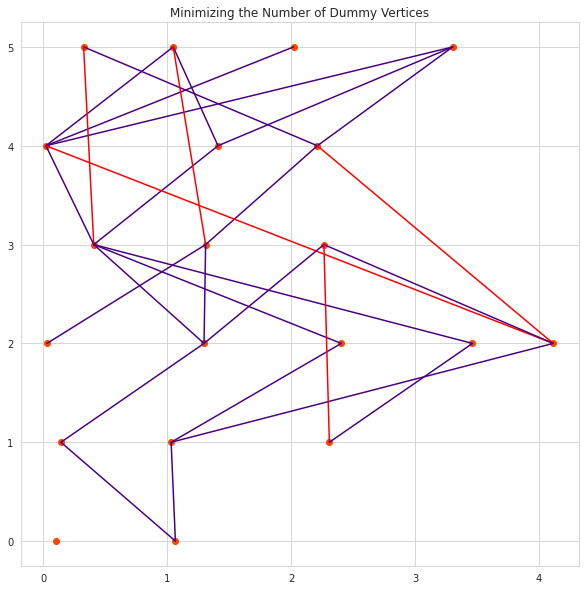

In [ ]:
sns.set_style("whitegrid")
in_edges = find_incomings()  

plt.figure(figsize=(10, 10))
plt.scatter(res_coords_2[:, 0], res_coords_2[:, 1], c='orangered', marker='o')
for i in range(len(in_edges)):
  for v in in_edges[i]:
    color = 'indigo'
    if (res_coords_2[v][1] - res_coords_2[i][1] > 1):
      color = 'red'
    plt.plot([res_coords_2[i][0], res_coords_2[v][0]], 
            [res_coords_2[i][1], res_coords_2[v][1]], color = color)

plt.title("Minimizing the Number of Dummy Vertices")
plt.show()

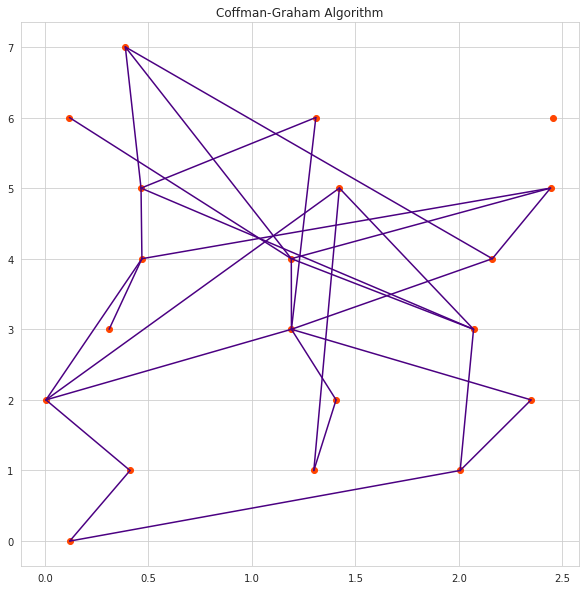

In [ ]:
sns.set_style("whitegrid")
res_coords_1 = layers_to_coords(res_levels_1)

plt.figure(figsize=(10, 10))
plt.scatter(res_coords_1[:, 0], res_coords_1[:, 1], c='orangered', marker='o')
for i in range(len(in_edges)):
  for v in in_edges[i]:
    color = 'indigo'
    plt.plot([res_coords_1[i][0], res_coords_1[v][0]], 
            [res_coords_1[i][1], res_coords_1[v][1]], color = color)

plt.title("Coffman-Graham Algorithm")
plt.show()

Добавление dummy-вершин непосредственно:

In [ ]:
def add_dummy_vertices(levels, coords):
  new_nodes = list(np.arange(len(nodes)))
  new_in_nodes = []
  in_nodes = find_incomings()  
  for e in find_incomings():
    new_in_nodes.append(e)
  cur_v = len(nodes)
  new_levels = []
  for l in levels:
    new_levels.append(l)
  for i in range(len(in_nodes)):
    edges_i = in_nodes[i]
    for v in edges_i:
      cur_lag = coords[v][1] - coords[i][1]
      if (cur_lag > 1):
        new_in_nodes[i].remove(v)
        prev = i
        cur_layer = int(coords[i][1]) + 1
        new_in_nodes[prev].append(cur_v)
        for dum in range(int(cur_lag) - 1):
          new_nodes.append(cur_v)
          new_in_nodes.append([])
          
          if (dum < cur_lag - 2):
            new_in_nodes[cur_v] = [cur_v + 1]
          else:
            new_in_nodes[cur_v].append(v)

          prev = cur_v
          new_levels[cur_layer].append(cur_v)
          cur_v += 1
          cur_layer += 1

  return new_levels, new_in_nodes, new_nodes 

In [ ]:
res_levels_1 = do_distribute(3)
res_levels_2 = do_distribute()
res_coords_1 = layers_to_coords(res_levels_1)
res_coords_2 = layers_to_coords(res_levels_2)

dum_levels_1, dum_ins_1, dum_nodes_1 = add_dummy_vertices(res_levels_1, res_coords_1)
dum_levels_2, dum_ins_2, dum_nodes_2 = add_dummy_vertices(res_levels_2, res_coords_2)

In [ ]:
def dummy_layers_to_coords(levels, noddes):
  res_coords = np.zeros((len(noddes), 2))
  for i in range(len(levels)):
    for j in range(len(levels[i])):
      cur = levels[i][j]
      res_coords[cur][0] = j + random.random() * 0.5
      res_coords[cur][1] = i
  return res_coords

In [ ]:
dum_coords_1 = dummy_layers_to_coords(dum_levels_1, dum_nodes_1)
dum_coords_2 = dummy_layers_to_coords(dum_levels_2, dum_nodes_2)

Рисунки:

Dummy-вершины зеленого цвета, а обычные - рыжего.

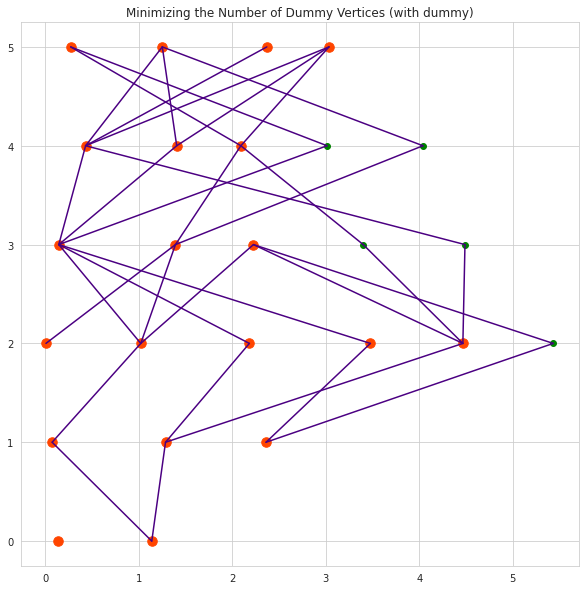

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(dum_coords_2[:len(nodes), 0], dum_coords_2[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(dum_coords_2[len(nodes):, 0], dum_coords_2[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_2)):
  for v in dum_ins_2[i]:
    color = 'indigo'
    if (dum_coords_2[v][1] - dum_coords_2[i][1] > 1):
      color = 'red'
    plt.plot([dum_coords_2[i][0], dum_coords_2[v][0]], 
            [dum_coords_2[i][1], dum_coords_2[v][1]], color = color)

plt.title("Minimizing the Number of Dummy Vertices (with dummy)")
plt.show()

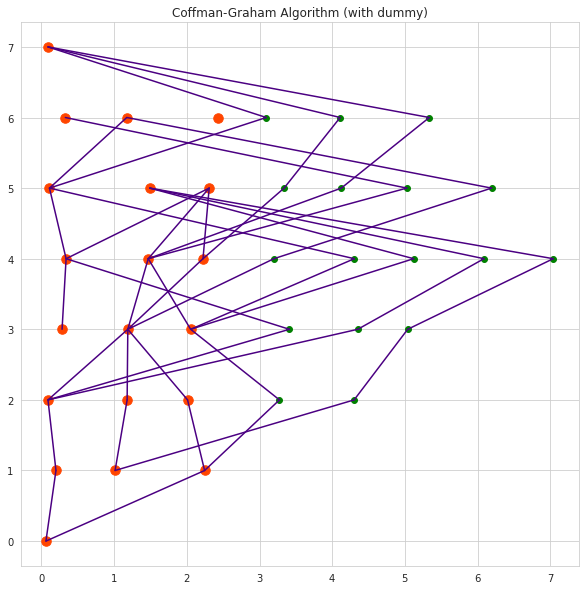

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(dum_coords_1[:len(nodes), 0], dum_coords_1[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(dum_coords_1[len(nodes):, 0], dum_coords_1[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_1)):
  for v in dum_ins_1[i]:
    color = 'indigo'
    plt.plot([dum_coords_1[i][0], dum_coords_1[v][0]], 
            [dum_coords_1[i][1], dum_coords_1[v][1]], color = color)

plt.title("Coffman-Graham Algorithm (with dummy)")
plt.show()

Как видим, в алгоритме Грэхема—Коффмана действительно больше dummy-вершин.

Минимизация числа пересечений ребер между слоями.

В эвристическом решении использую медиану, а не среднее арифметическое (ввиду изложенных на лекции соображений по этому поводу).

In [ ]:
def get_median(level, incoming, level_coords):
  coords = []
  if len(incoming) == 0:
    return 0
  for i in level:
    if i in incoming:
      coords.append(level_coords[level.index(i)])
  return np.median(np.array(coords))

def get_minimized_crossings(levels, incoming):
  level_coords = []
  for l in range(len(levels)):
    level_coords.append([])
  level_coords[-1] = levels[-1]
  
  for l in reversed(range(0, len(levels) - 1)):
    coords = []
    for v in levels[l]:
      coords.append(get_median(levels[l + 1], incoming[v], level_coords[l + 1]))
    res = np.argsort(coords)
    res_layer = []
    cur_l = levels[l]
    for r in res:
      res_layer.append(cur_l[r])
    level_coords[l] = res_layer 
  return level_coords


In [ ]:
eur_levels_1 = get_minimized_crossings(dum_levels_1, dum_ins_1)
eur_levels_2 = get_minimized_crossings(dum_levels_2, dum_ins_2)

In [ ]:
def res_layers_to_coords(levels, noddes):
  res_coords = np.zeros((len(noddes), 2))
  for i in range(len(levels)):
    for j in range(len(levels[i])):
      cur = levels[i][j]
      res_coords[cur][0] = j
      res_coords[cur][1] = i
  return res_coords

In [ ]:
eur_coords_1 = res_layers_to_coords(eur_levels_1, dum_nodes_1)
eur_coords_2 = res_layers_to_coords(eur_levels_2, dum_nodes_2)

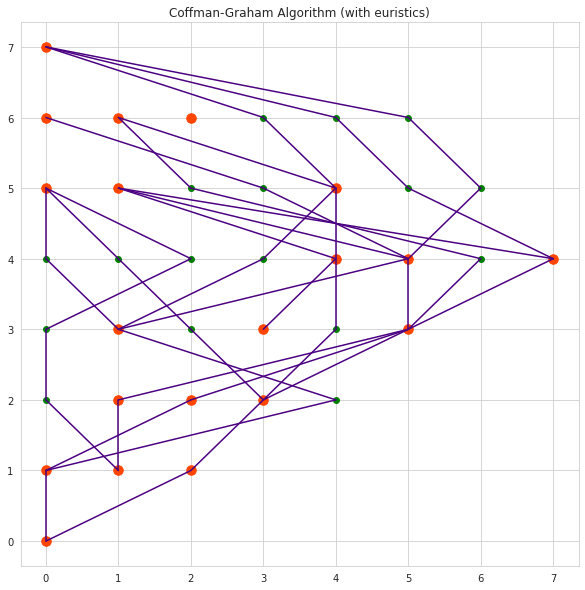

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(eur_coords_1[:len(nodes), 0], eur_coords_1[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(eur_coords_1[len(nodes):, 0], eur_coords_1[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_1)):
  for v in dum_ins_1[i]:
    color = 'indigo'
    plt.plot([eur_coords_1[i][0], eur_coords_1[v][0]], 
            [eur_coords_1[i][1], eur_coords_1[v][1]], color = color)

plt.title("Coffman-Graham Algorithm (with euristics)")
plt.show()

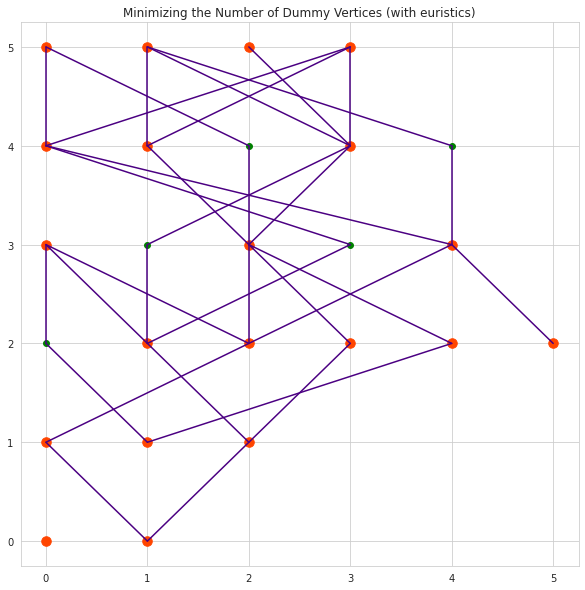

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(eur_coords_2[:len(nodes), 0], eur_coords_2[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(eur_coords_2[len(nodes):, 0], eur_coords_2[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_2)):
  for v in dum_ins_2[i]:
    color = 'indigo'
    plt.plot([eur_coords_2[i][0], eur_coords_2[v][0]], 
            [eur_coords_2[i][1], eur_coords_2[v][1]], color = color)

plt.title("Minimizing the Number of Dummy Vertices (with euristics)")
plt.show()

In [ ]:
def one_level_crossings(level, up_level, incomings):
  num_res = 0
  for i in range(len(level)):
    for j in range(i + 1, len(level)):
      u = level[i]
      v = level[j]
      # по циклу: u левее v
      for uu in incomings[u]:
        for vv in incomings[v]:
          if up_level.index(uu) > up_level.index(vv):
            num_res += 1
  return num_res

def find_crossings(level, up_level, down_level, incomings):
  return one_level_crossings(level, up_level, incomings) + one_level_crossings(down_level, level, incomings)

def local_search_in_layer(layers, num, incomings):
  cur_cross = find_crossings(layers[num], layers[num + 1], layers[num - 1], incomings)
  u_opt = -1
  v_opt = -1
  cur_layer = layers[num]

  for i in range(len(cur_layer)):
    for j in range(i + 1, len(cur_layer)):
      u = cur_layer[i]
      v = cur_layer[j]
      new_layer = list(np.copy(cur_layer))
      new_layer[i] = v
      new_layer[j] = u
      new_res = find_crossings(new_layer, layers[num + 1], layers[num - 1], incomings)
      if (new_res < cur_cross):
        cur_cross = new_res
        u_opt = i
        v_opt = j

  if (u_opt != -1):
    t = cur_layer[u_opt]
    cur_layer[u_opt] = cur_layer[v_opt]
    cur_layer[v_opt] = t
    layers[num] = cur_layer
    return layers, 0
  return layers, 1


def do_local_search(layers, incomings, max_passes = 10):
  best_layers = np.copy(layers)
  optimized = np.zeros(len(layers) - 2)
  cur_pass = 0
  while((np.sum(optimized)< len(layers) - 2) and (cur_pass < max_passes)):
    cur_pass += 1
    for l in range(1, len(layers) - 1):
      best_layers, status = local_search_in_layer(best_layers, l, incomings)
      optimized[l - 1] = status
  return best_layers


In [ ]:
eur_levels_1 = get_minimized_crossings(dum_levels_1, dum_ins_1)
eur_levels_2 = get_minimized_crossings(dum_levels_2, dum_ins_2)

best_levels_1 = do_local_search(eur_levels_1, dum_ins_1, 15)
best_levels_2 = do_local_search(eur_levels_2, dum_ins_2, 15)

best_coords_1 = res_layers_to_coords(best_levels_1, dum_nodes_1)
best_coords_2 = res_layers_to_coords(best_levels_2, dum_nodes_2)

Итоговая картинка:

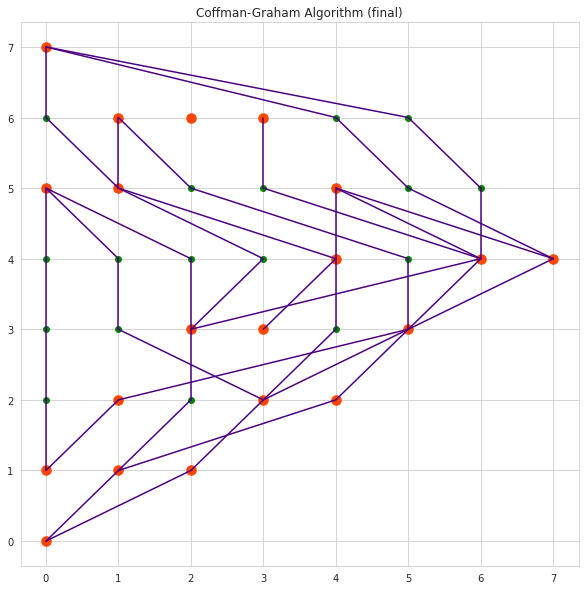

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(best_coords_1[:len(nodes), 0], best_coords_1[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(best_coords_1[len(nodes):, 0], best_coords_1[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_1)):
  for v in dum_ins_1[i]:
    color = 'indigo'
    plt.plot([best_coords_1[i][0], best_coords_1[v][0]], 
            [best_coords_1[i][1], best_coords_1[v][1]], color = color)

plt.title("Coffman-Graham Algorithm (final)")
plt.show()

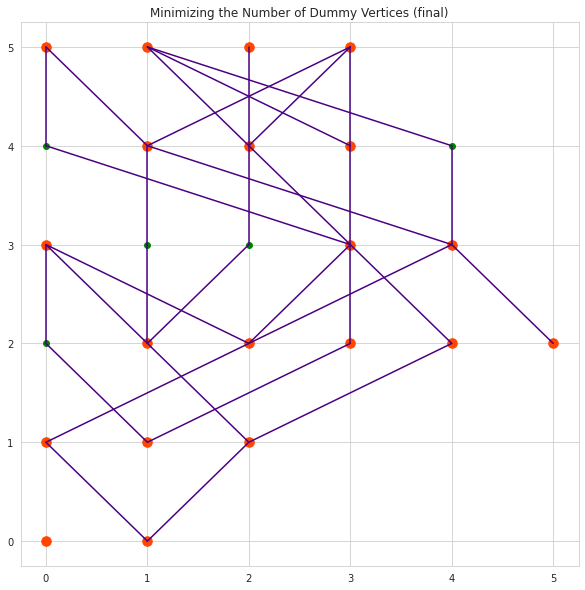

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(best_coords_2[:len(nodes), 0], best_coords_2[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(best_coords_2[len(nodes):, 0], best_coords_2[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_2)):
  for v in dum_ins_2[i]:
    color = 'indigo'
    plt.plot([best_coords_2[i][0], best_coords_2[v][0]], 
            [best_coords_2[i][1], best_coords_2[v][1]], color = color)

plt.title("Minimizing the Number of Dummy Vertices (final)")
plt.show()

В целом, можно еще приписать сами номера вершин:

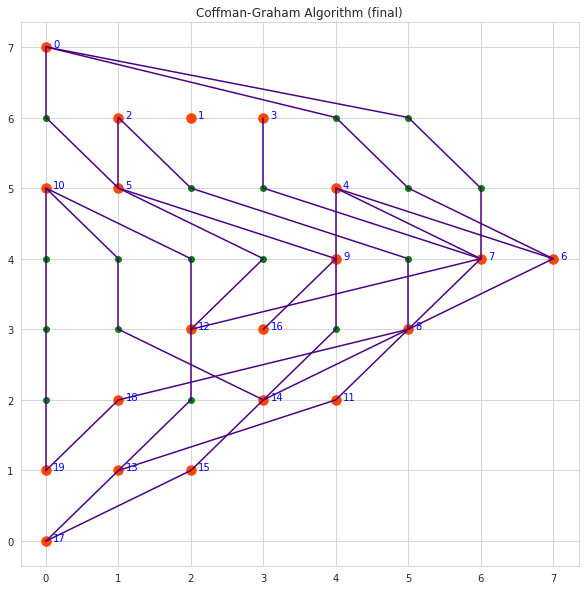

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(best_coords_1[:len(nodes), 0], best_coords_1[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(best_coords_1[len(nodes):, 0], best_coords_1[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_1)):
  for v in dum_ins_1[i]:
    color = 'indigo'
    plt.plot([best_coords_1[i][0], best_coords_1[v][0]], 
            [best_coords_1[i][1], best_coords_1[v][1]], color = color)

for i, (a, b) in enumerate(zip(best_coords_1[:len(nodes), 0], best_coords_1[:len(nodes), 1])):
  plt.text(a + 0.1, b, nodes[i][1:], color='b')

plt.title("Coffman-Graham Algorithm (final)")
plt.show()

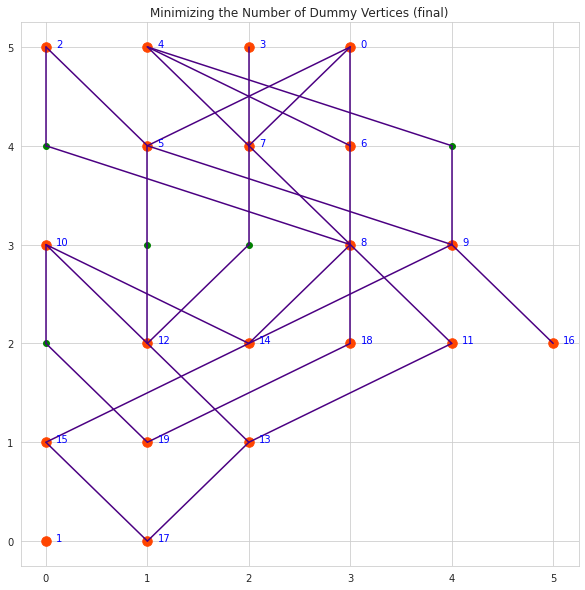

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(best_coords_2[:len(nodes), 0], best_coords_2[:len(nodes), 1], c='orangered', marker='o', s=90)
plt.scatter(best_coords_2[len(nodes):, 0], best_coords_2[len(nodes):, 1], c='green', marker='o', s=35)
for i in range(len(dum_ins_2)):
  for v in dum_ins_2[i]:
    color = 'indigo'
    plt.plot([best_coords_2[i][0], best_coords_2[v][0]], 
            [best_coords_2[i][1], best_coords_2[v][1]], color = color)

for i, (a, b) in enumerate(zip(best_coords_2[:len(nodes), 0], best_coords_2[:len(nodes), 1])):
  plt.text(a + 0.1, b, nodes[i][1:], color='b')

plt.title("Minimizing the Number of Dummy Vertices (final)")
plt.show()

В целом, оба алгоритма сработали неплохо, картинки получились визуально понятные. Но лично мне больше понравился результат работы алгоритма Грэхема—Коффмана, так как он выглядит чуть более аккуратно.